In [1]:
import numpy as np
import os
from astropy.io import fits
from astropy.stats import LombScargle
from photutils import aperture_photometry as photometry
from photutils import CircularAperture as circle
from photutils import CircularAnnulus as annulus
from photutils import RectangularAperture as rectangle
from photutils import ApertureMask as mask
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
np.set_printoptions(threshold=np.nan)


                                                Initial Setup

In [2]:
initial_directory = '/Users/Olive/Desktop/kelt pipeline/Full Images' # path of directory that contains full image fits files
cutout_directory = '/Users/Olive/Desktop/kelt pipeline/testCut/' # location for image cutouts

all_files=os.listdir(initial_directory) #extract list of files
file_count = len(all_files) # gives number of files in directory
sort_files = sorted(all_files) # sort directory in alphanumeric order
full_img_list = [os.path.join(initial_directory, sort_files[i]) for i in range(0,file_count)] # create file path names for full image files

                                                Creating Image Cutouts

In [ ]:
#cell containing upcoming variables

cutout_x_start = 20
cutout_x_stop = 40
cutout_y_start = 80
cutout_y_stop = 100

In [19]:
#a function to create new image cutouts
for i in range(0,file_count):
    image=fits.open(full_img_list[i]) #open file
    imageData = image[1].data  #take out data from file (data is in 'section' 1)
    image.close()
    image_cutout_data= imageData[cutout_x_start:cutout_x_stop, cutout_y_start:cutout_y_stop]  #choose area of data to keep
    image_cutout = fits.PrimaryHDU(image_cutout_data)  #assign data to new fits file
    cutoutName='cutout_'+all_files[i][len(all_files[i])-20:] #appends 'cutout' to the date and id of photo
    destination=cutout_directory+cutoutName  #define destination of new file. CHANGE, GO THROUGH ALL IMAGES IN A STAR
    image_cutout.writeto(destination)  #save fits file    

NameError: name 'cutout_x_start' is not defined

In [3]:
# create file path names for full image files
cutout_img_list = [os.path.join(cutout_directory, sorted(os.listdir(cutout_directory))[i]) for i in range(0,file_count)]
open_cutouts =[]
for i in range (0,file_count):
    image=fits.open(cutout_img_list[i]) #open file
    imageData = image[0].data  #take out data from file (data is in 'section' 1)
    image.close()
    open_cutouts.append(imageData)

might need to figure out how to append the header data in the future

                                        Producing a Light Curve and Phase Curve

In [9]:
# cell for upcoming variables not previously defined
display_file = 1 # target file number to display target image
target_img_size = 20 # x by x pixel size of target image

x_aperture = 9 # x coordinate of target aperture center within the star cutout 
y_aperture = 9 # y coordinate of target aperture center within the star cutout 
r = 2 # radius of target aperture

x_background = x_aperture # x coordinate of background annulus center
y_background = y_aperture # y coordinate of background annulus center
r_in = 8 # inner radius of background annulus
r_out = r_in + 1 # outer radius of background annulus

start = 0 # first image file to include in photometry
stop = 800 # number of images to include in photometry

low_period = 1.5 # lowest period for LombScargle to test on target star
high_period = 100 # highest period for LombScargle to test on target star

comparison_stars= np.loadtxt('FNAQL_stars.txt', skiprows=1)

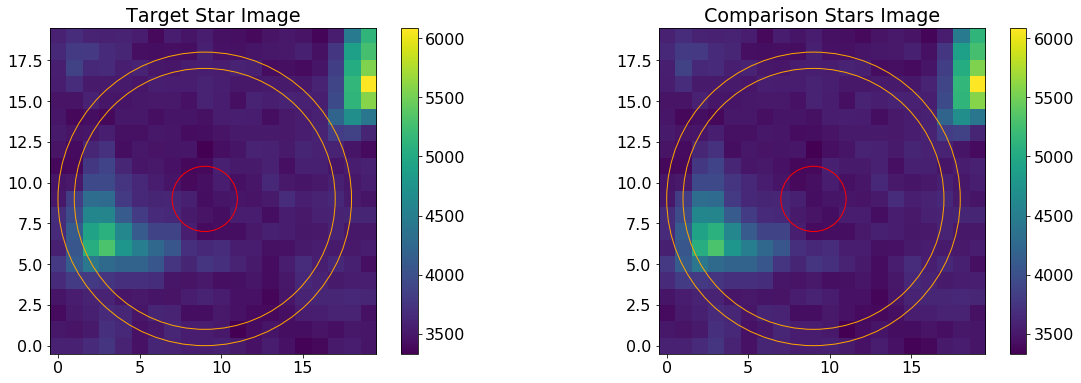

IndexError: index 1 out of range for table with length 1

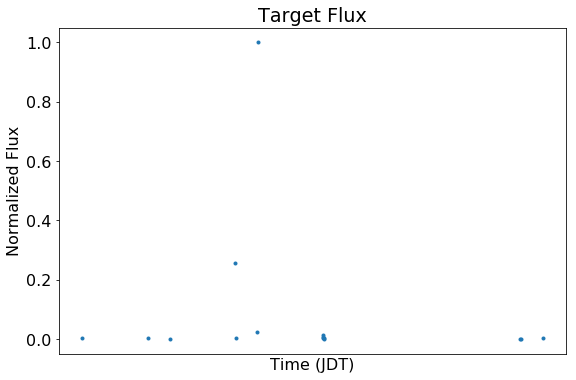

In [14]:
# The following data for this star is given in the VizieR database
# name: FN Aql, period: 9.48151 days, RA and dec: (19:12:47.3112, +03:33:26.712), magnitude range: (8.110, 8.680)

center = len(open_cutouts[display_file-1])/2 # calculate center location of target image
target = open_cutouts[display_file-1][int(center-target_img_size/2):int(center+target_img_size/2),int(center-target_img_size/2):int(center+target_img_size/2)] # create array of target image data values for specified file

aperture_main_cutout = circle((x_aperture,y_aperture), r) # create circular aperture around target
background_main_cutout = annulus((x_background,y_background), r_in, r_out) # create annulus for background flux

# create target image with target aperture and background annulus

mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

plt.subplot(121)
plt.title('Target Star Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture_main_cutout.plot(color='red')
background_main_cutout.plot(color='orange')


offset = (len(open_cutouts[display_file-1])-target_img_size)/2 # calculate difference between center coordinates of target image and comparison stars image
aperture_large_img = circle((x_aperture+offset,y_aperture+offset), r) # place aperture on target star in comparison stars image
background_large_img = annulus((x_background+offset,y_background+offset), r_in, r_out) # place background annulus so that it is surrounding target star in comparison stars image

# define comparison star coordinates and radii from an existing text file 

comparison_star_circles= [] # empty list to put new star circles into
for i in range(len(comparison_stars)):
    newStar = comparison_stars[i] #ientify row for clearer use in the next line
    newStar_circle = circle((newStar[0],newStar[1]), r=newStar[2]) 
    comparison_star_circles.append(newStar_circle) # create list of circles to plot
    

# create comparison stars image with target aperture, comparison apertures, and background annulus

plt.subplot(122)
plt.title('Comparison Stars Image')
plt.imshow(open_cutouts[display_file-1], origin='lower')
plt.colorbar()
aperture_large_img.plot(color='red')
background_large_img.plot(color='orange')

for i in range(len(comparison_star_circles)):
    comparison_star_circles[i].plot(color='red')

plt.show()


background_mask = background_large_img.to_mask(method='center') # create mask over pixels in background annulus that have their centers within the annulus 
background_data = [background_mask[0].multiply(open_cutouts[i]) for i in range(start,stop)] # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
background_flux = [background_data[i][background_mask[0].data > 0] for i in range(start,stop)] # create array of flux values contained in mask
background_median = [np.median(background_flux[i]) for i in range(start,stop)] # find median of background flux array
 
target_sum = [photometry(open_cutouts[i], aperture_large_img, method = 'exact') for i in range(start,stop)] # sum up exact amount of flux contained in the target aperture
target_background_sum = [background_median[i] * aperture_large_img.area() for i in range(start,stop)] # multiply background median by area of aperture to get background flux contained in aperture
target_subtract = np.array([target_sum[i]['aperture_sum'] - target_background_sum[i] for i in range(start,stop)]) # subtract background flux in aperture from aperture's total flux
target_flux = target_subtract[target_subtract > 0] # disregard zero flux values 

time=[]
for i in range(0,len(target_flux)):
    original_file = fits.open(full_img_list[i])
    original_file_time= original_file[1].header['JDT']
    time.append(original_file_time)
    original_file.close


# create target flux vs. time plot

plt.subplot(121)
plt.title('Target Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, 100))

new_target_flux = []
           
for i in range(0,len(target_flux)):
    norm = target_flux[i]/max(target_flux)
    new_target_flux.append(norm)
           
plt.plot(time, new_target_flux, '.')

#**neew to turn into a collection loop**
comparison_sum = []
for j in range(0,len(comparison_star_circles)):
    for i in range(0, len(open_cutouts)):
        adding = photometry(open_cutouts[i], comparison_star_circles[j], method = 'exact') 
        comparison_sum.append(adding)

comparison_background_sum = [[background_median[i] * comparison_star_circles[j].area() for i in range(start,stop)] for j in range(0,len(comparison_star_circles))] # multiply background median by area of each aperture to get background flux contained in each aperture
comparison_subtract = np.array([[comparison_sum[j][i]['aperture_sum'] - comparison_background_sum[j][i] for i in range(start,stop)] for j in range(0,len(comparison_star_circles))]) # subtract background flux in each aperture from each aperture's total flux
comparison_total = comparison_subtract.sum(axis=0) # sum up the background subtracted flux for all comparison stars
comparison_flux = comparison_total[comparison_total > 0] # disregard zero flux values


# create comparison flux vs. time plot

plt.subplot(122)
plt.title('Comparison Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/5,-2)))
plt.plot(time, comparison_flux/max(comparison_flux), '.')
plt.show()


final_flux = np.subtract(target_flux, comparison_flux) # subtract target flux from comparison flux


# create target light curve with target flux minus comparison flux vs. time 

plt.title('Target Light Curve')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/10,-2)))
plt.plot(time, (final_flux - min(final_flux))/(max(final_flux)-min(final_flux)), '.') 
plt.show()

frequency, power = LombScargle(time, final_flux).autopower(minimum_frequency = 1/high_period, maximum_frequency = 1/low_period) # use Lomb-Scargle Periodogram to test period range on target 


# create target periodogram with power vs. period

plt.subplot(121)
plt.plot(1/frequency, power)
plt.title('Target Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Power')
    
    
best_frequency = frequency[np.argmax(power)] # find frequency with highest power value
period = 1/best_frequency # convert this frequency to a period
low = np.argmin(final_flux) # find lowest value of flux 
phase_offset = 0.5 - np.remainder(time[low], period) / period # calculate phase offset so that lowest flux value in each cycle is located at half the period
phase = np.remainder(time + phase_offset * period, period * 2) / period # calculate the phase of the target flux for two cycles


# create target phase curve with flux vs. phase

plt.subplot(122)
plt.plot(phase, (final_flux - min(final_flux))/max(final_flux-min(final_flux)), '.')
plt.title('Target Phase Curve')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.show()


# print the most likely period with its corresponding power value for the target star

print("best period for range", low_period, "to", high_period, "days =", period, "days")
print("power value for best period = ", max(power))

                                                Creating Flux Histogram

In [24]:
# cell for upcoming variables not previously defined

target_img_size = 20 # pixel size of target image

# target star aperture and background annulus center coordinates and radii 
#  for target image are used from section "producing a light curfe an phase curve"

bin_size = 5000 # bin size for histogram

NameError: name 'aperture_main_cutout' is not defined

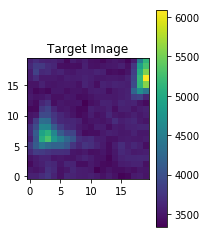

In [28]:
# create array of target image data values for specified file

first_x = int(center-target_img_size/2)
last_x = int(center+target_img_size/2)
first_y = first_x
last_y = last_x
target = open_cutouts[display_file-1][first_x:last_x,first_y:last_y] 

# create target image with target aperture and background annulus

plt.subplot(121)
plt.title('Target Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture_main_cutout.plot(color='red')
background_main_cutout.plot(color='orange')

aperture_mask = aperture_main_cutout.to_mask(method='center') # create mask over pixels in target aperture that have their centers within the annulus 
aperture_data = aperture_mask[0].multiply(target) # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
aperture_flux = aperture_data[aperture_mask[0].data > 0] # create array of flux values contained in mask

# create bins for histogram up to highest flux value in aperture
bins = np.arange(0,max(np.ndarray.flatten(target)+bin_size),bin_size) 

# create flux histrogram of values within target aperture
plt.subplot(122)
plt.hist(aperture_flux, bins);
plt.title('Flux Histogram')
plt.xlabel('Flux')
plt.ylabel('Frequency');
plt.show()

                                            Examining Abnormal Flux Values

In [23]:
# cell for upcoming variables not previously defined

img_file = 1 # target file number to display target image
img_size = 20 # pixel size of target image

# target star aperture and background annulus center coordinates and radii 
#   for target image are used from section "producing a light curfe an phase curve"


In [6]:
center = len(surroundings_data[img_file-1])/2 # calculate center location of target image
target = surroundings_data[img_file-1][int(center-img_size/2):int(center+img_size/2),int(center-img_size/2):int(center+img_size/2)] # create array of target image data values for specified file

surroundings_data = [np.loadtxt(cutout_img_list[i], dtype='float') for i in range(0,file_count)]  # get data from surrounding area cutouts

# create target image with target aperture and background annulus

mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

plt.subplot(121)
plt.title('Target Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture_main_cutout.plot(color='red')
background_main_cutout.plot(color='orange')


target_data = [surroundings_data[i][int(center-img_size/2):int(center+img_size/2),int(center-size/2):int(center+size/2)] for i in range(0,file_count)] # create array of target image data values for all files
target_sum = [photometry(target_data[i], aperture_main_cutout, method = 'exact') for i in range(0,file_count)] # sum up exact amount of flux contained in the target aperture
target_flux = np.array([target_sum[i]['aperture_sum'] for i in range (0,file_count)]) # get flux of target aperture without disregarding zero flux values


# create surrounding area image with target aperture and background annulus

plt.subplot(122)
plt.title('Target Image Surroudings')
plt.imshow(surroundings_data[img_file-1], origin='lower')
plt.colorbar() 
aperture_main_cutout.plot(color='red') 
aperture_main_cutout.plot(color='orange')
plt.show()

time = [open_files[i][1].header['JDT'] for i in range(0,len(target_flux))] # get time values for target image data


# create light curve for target flux with zero flux values

plt.title('Target Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/10,-2)))
plt.plot(time, target_flux, '.')
plt.show()


low_flux = (sum(target_flux) / float(len(target_flux)))/10 # !!changed!! an order of magnitude less than target flux avg
high_flux = np.inf # upper limit for target flux values


# print flux values and corresponding file number for values that fall outside specified limits

print("Low Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux < low_flux])):
    print(np.add(np.where(target_flux < low_flux),1)[0][i], "        ", target_flux[target_flux < low_flux][i])
print("")
print("")
print("")
print("High Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux > high_flux])):
    print(np.add(np.where(target_flux > high_flux),1)[0][i], "        ", target_flux[target_flux > high_flux][i])

NameError: name 'surroundings_data' is not defined